In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ue21cs342aa2/sample_submission.csv
/kaggle/input/ue21cs342aa2/train.csv
/kaggle/input/ue21cs342aa2/test.csv


# Importing the Required Libraries

In [2]:
# importing libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import *
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_path = '/kaggle/input/ue21cs342aa2/train.csv'
test_path = '/kaggle/input/ue21cs342aa2/test.csv'

# Importing the Datasets

In [4]:
df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
df.head()

,id,Date,Open,Close,Volume,Strategy
0,0,2015-06-01,66.208486,75.609978,298506300,Hold
1,1,2015-06-08,64.116235,74.443331,227974800,Hold
2,2,2015-06-15,47.701942,71.140831,250670900,Buy
3,3,2015-06-22,54.754816,72.881344,223614300,Hold
4,4,2015-06-29,48.031899,66.284718,406814900,Buy


# Descriptive Statistics

In [5]:
print('Descriptive statistics')
print(df.describe())
# print null values
print('Null values')
print(df.isnull().sum())
# print shape of dataframe
print('Shape of dataframe')
print(df.shape)

Descriptive statistics
               id        Open       Close        Volume
count  300.000000  300.000000  300.000000  3.000000e+02
mean   149.500000   75.977813   79.430489  1.866300e+08
std     86.746758   16.158343   13.878395  7.952792e+07
min      0.000000   40.269435   47.979353  5.991330e+07
25%     74.750000   64.872395   69.689227  1.324862e+08
50%    149.500000   79.805683   82.991900  1.715536e+08
75%    224.250000   88.342927   89.719145  2.201842e+08
max    299.000000  102.558322  103.119373  6.935702e+08
Null values
id          0
Date        0
Open        0
Close       0
Volume      0
Strategy    0
dtype: int64
Shape of dataframe
(300, 6)


# Pre-Processing

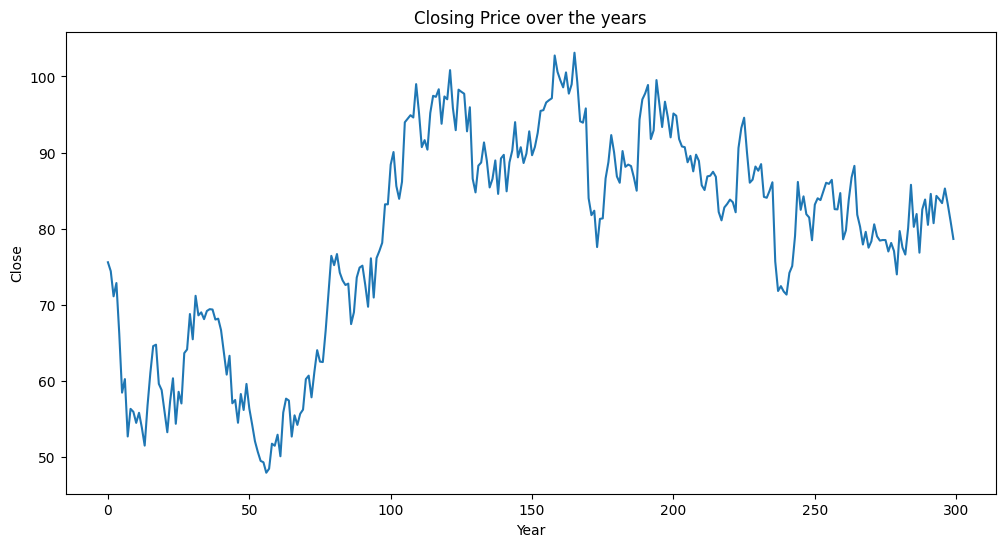

In [6]:
# convert to datetime
df['Date'] = pd.to_datetime(df['Date'])
# make a copy of the dataframe
df_copy = df.copy()
# plot the Close column
xlabel = 'Year'
ylabel = 'Close'
df_copy['Close'].plot(xlabel=xlabel, ylabel=ylabel,figsize=(12,6))
plt.title('Closing Price over the years')
plt.show()


# Feature Engineering

**Description of features:**

1)M16 : Moving Average 16 is calculated on the open price. M16 uses a window of 16 days and calculates the values based on the past 16 moving average of the open price.

2)M50 : Moving Average 50 is calculated on the open price. M16 uses a window of 50 days and calculates the values based on the past 50 moving average of the open price.

3)Buy : If M16 is greater than M50, it gives an indication that the price could go up mode in next few days. Hence Buy = 1 if M16 > M50 else 0.

4)Short : This is opposite of Buy. If M16 < M50, then 1 else 0. Short indicates that the price could drop in the next few days

5)Sentiment : Uses High and Low to indicate the trend of the price in a trading day. If High - Low < 0 then it indicates a down trend else an uptrend.

6)ROI : Stands for Return on Investment. Basically tracks the percentage increase in stock price since the first price of the dataset.

7)Percent Change : Percentage Increase or decrease in stock price compared to 
previous trading day.

8)VPT : Volume Price Trend Indicator is used to give strength of a upward or downward trend.

In [7]:
df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
DF = pd.concat([df,test_df])
DF = DF.reset_index(drop=True)
DF['M16'] = DF['Open'].rolling(16).mean()
DF['M50'] = DF['Open'].rolling(50).mean()
DF['M16'] = DF['M16'].fillna(method="bfill")
DF['M50'] = DF['M50'].fillna(method="bfill")
DF['Buy'] = np.where(DF['M16']>DF['M50'],1.0,0.0)
DF['Short'] = np.where(DF['M16']<DF['M50'],1.0,0.0)
DF['roi'] = (DF['Open'] - DF['Open'][0])/DF['Open'][0]
#DF['sentiment'] = np.where(DF['Open']-DF['Close']<0,0.0,1.0)
DF['percent_change'] = (DF['Open'] - DF['Open'].shift(1))/DF['Open'].shift(1)
DF['percent_change'] = DF['percent_change'].fillna(0)
DF['Date'] = pd.to_datetime(DF['Date'])
DF['VPT'] = 0
DF['VPT'] = DF['VPT'].shift(1) + (DF['Volume'] * (DF['Open']-DF['Open'].shift(1))/DF['Open'].shift(1))
DF['VPT'] = DF['VPT'].fillna(method='bfill')
DF = DF.set_index('Date')
df = DF[:1500]
test_df = DF[1500:]
print(test_df)

Empty DataFrame
Columns: [id, Open, Close, Volume, Strategy, M16, M50, Buy, Short, roi, percent_change, VPT]
Index: []


In [8]:
print(df.columns)

Index(['id', 'Open', 'Close', 'Volume', 'Strategy', 'M16', 'M50', 'Buy',
       'Short', 'roi', 'percent_change', 'VPT'],
      dtype='object')


In [9]:
print(test_df.shape)

(0, 12)


# Scaling of the Dataset

In [10]:
sc1 = StandardScaler()
sc2 = StandardScaler()
columns = ['Open','Close','Volume','roi','M16','M50','percent_change']
df[columns] = sc1.fit_transform(df[columns])
if not test_df.empty:
     test_df[columns] = sc1.transform(test_df[columns])
df['Close'] = sc2.fit_transform(df[['Close']])

In [11]:
df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Rolling Statistics

**Rolling average or running average:** It is a calculation done to analyze data points by creating a series of averages of different selections of the full data set.

In [12]:
rolmean = df['Close'].rolling(window=12).mean()
rolstd = df['Close'].rolling(window=12).std()

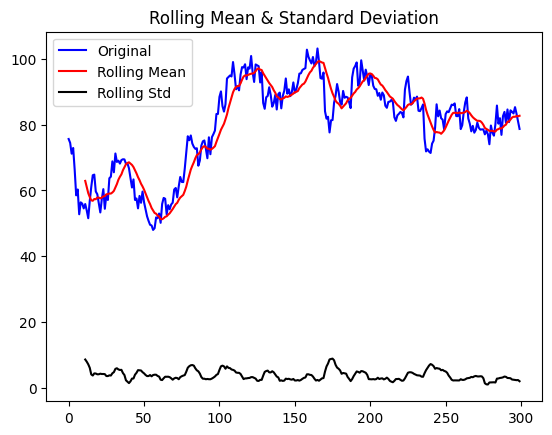

In [13]:
# plot rolling statistics
orig = plt.plot(df['Close'], color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Checking for Stationarity: Dickey-Fuller test

**Null hypothesis:** Data series is non-stationary

**Alternative hypothesis:** Data series stationary

If p-value is lesser than 0.05, then we reject the null hypothesis. This implies that the series is stationary.

If p-value is greater than 0.05, then we fail to reject the null hypothesis. This implies that the series is non-stationary.


In [14]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(df['Close'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -1.808006
p-value                          0.376494
#Lags Used                       1.000000
Number of Observations Used    298.000000
Critical Value (1%)             -3.452486
Critical Value (5%)             -2.871288
Critical Value (10%)            -2.571964
dtype: float64


Since the p-value is greater than 0.05, we fail to reject the null hypothesis.

This shows the series is non-stationary.

In [15]:
df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Visualization for Non-Stationarity

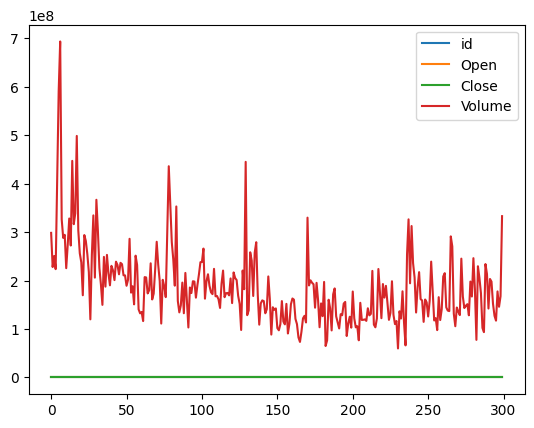

In [16]:
df.plot()
pyplot.show()

The above graph shows trend in the time-series. 

# Test for Stationarity 

In [17]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [18]:
adfuller_test(df['Close'])

ADF Test Statistic : -1.8080055426222836
p-value : 0.37649446979222034
#Lags Used : 1
Number of Observations Used : 298
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


# Remove rows with missing 'Close' values

In [19]:
df.dropna(subset=['Close'], inplace=True)  
decomposition = seasonal_decompose(df['Close'], period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Components of Time-Series Data

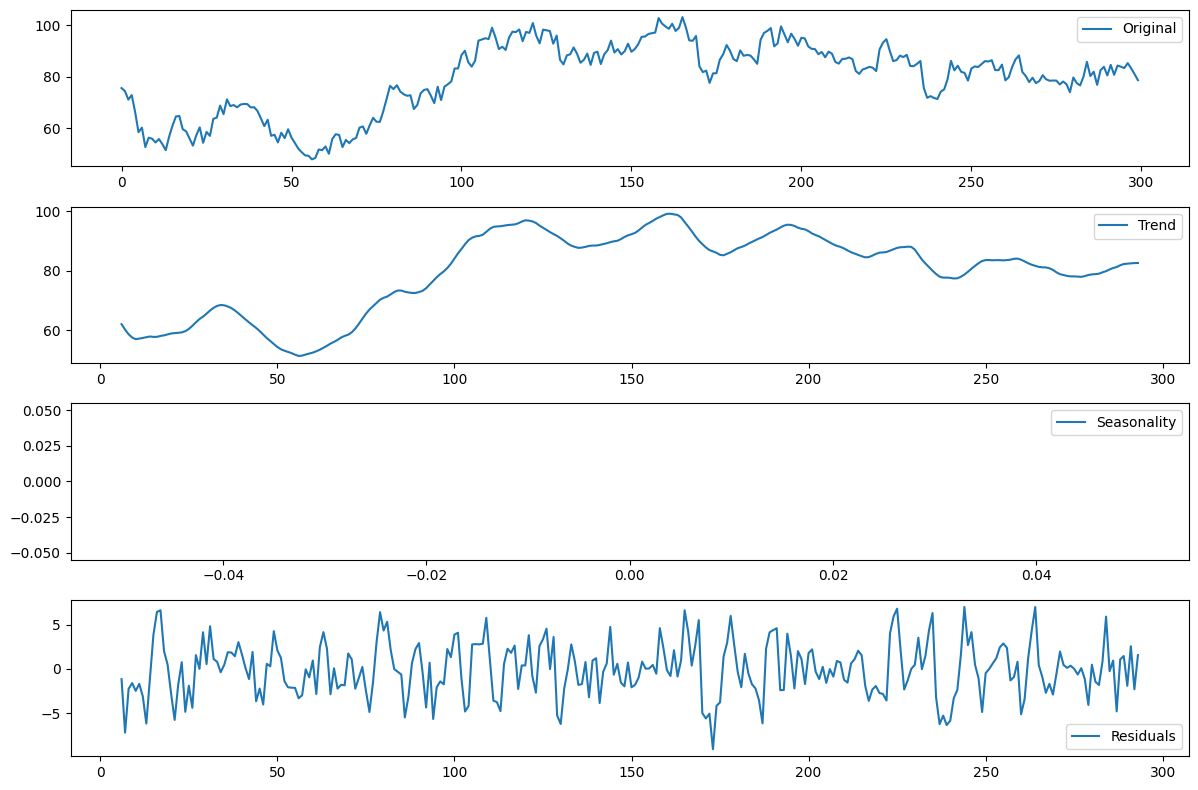

In [20]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df['Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal[1300:1500], label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show(block=False)

# Removing Non-Stationary Components

Computing the two variables used to do Dickey-Fuller test.

In [21]:
df_stationary = df.copy()
df_stationary['Close First Difference'] = df['Close'] - df['Close'].shift(1)
df_stationary['Close Second Difference'] = df['Close'] - df['Close'].shift(2)

In [22]:
adfuller_test(df_stationary['Close First Difference'].dropna())

ADF Test Statistic : -19.615947588858155
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 298
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Since the p-value is less than 0.05, we reject the null hypothesis.

This shows that the series is stationary.

In [23]:
adfuller_test(df_stationary['Close Second Difference'].dropna())

ADF Test Statistic : -4.609329110383769
p-value : 0.000124150870715808
#Lags Used : 15
Number of Observations Used : 282
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Since the p-value is less than 0.05, we reject the null hypothesis.

This shows that the series is stationary.

# Visualization after removing non-stationary components

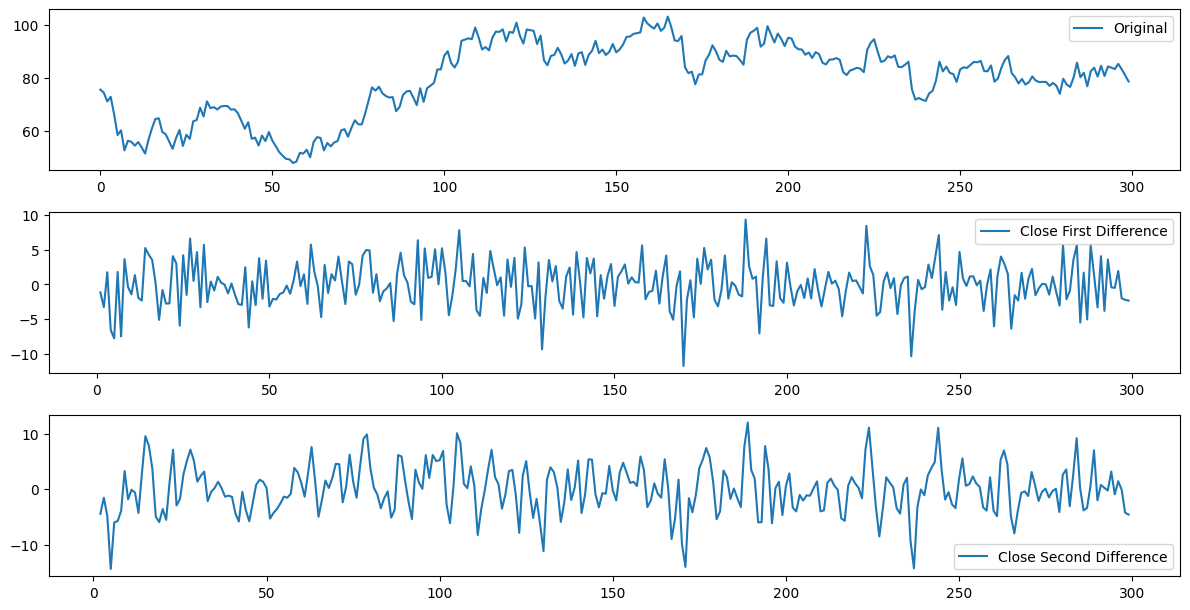

In [24]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df['Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(df_stationary['Close First Difference'], label='Close First Difference')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(df_stationary['Close Second Difference'].dropna(), label='Close Second Difference')
plt.legend(loc='best')
plt.tight_layout()
plt.show(block=False)

# Decomposition and Plotting of Trend, Seasonality and Residuals

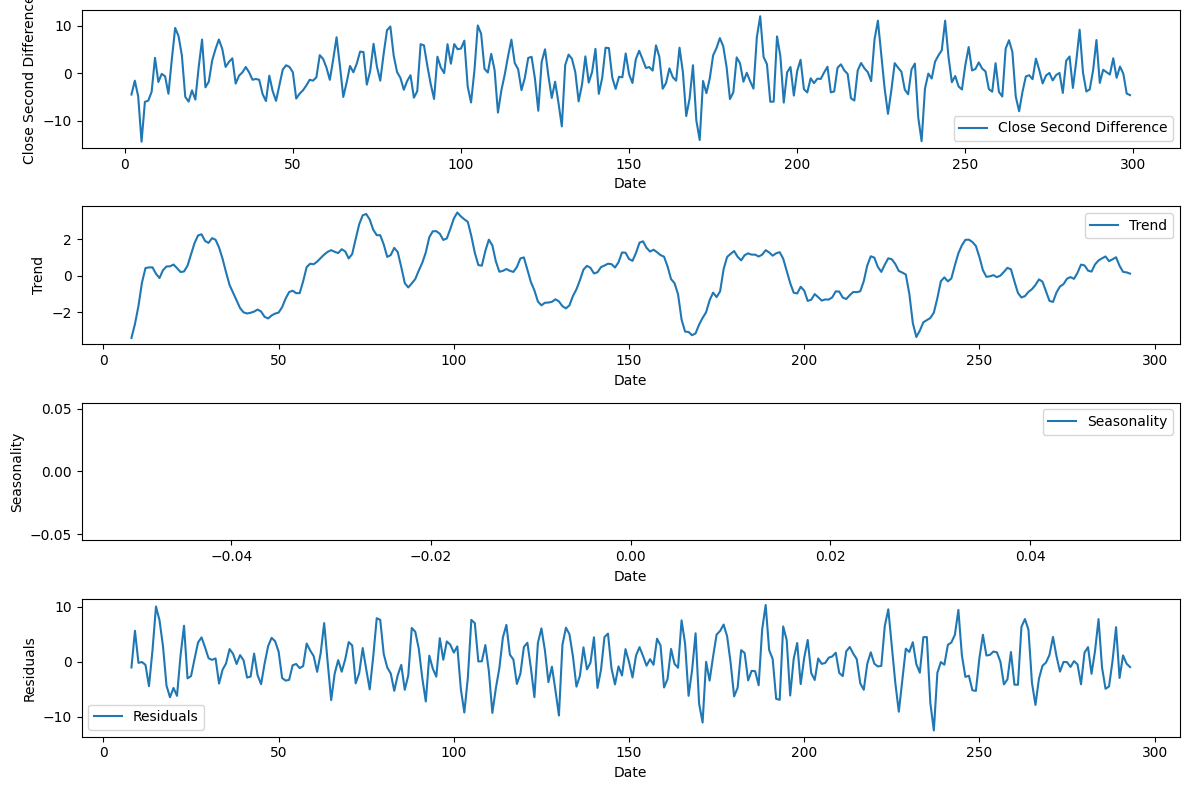

In [25]:
# Decomposition
decomposition = seasonal_decompose(df_stationary['Close Second Difference'].dropna(), period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot Trend, Seasonality, and Residuals
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df_stationary['Close Second Difference'].dropna(), label='Close Second Difference')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Close Second Difference')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Trend')

plt.subplot(413)
plt.plot(seasonal[1300:1500], label='Seasonality')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Seasonality')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


In [26]:
csd = pd.DataFrame(df_stationary['Close Second Difference'].dropna())
csd = csd.reset_index(drop=True)

# ACF and PACF Plots

In [27]:
# ACF and PACF
lag_acf = acf(csd, nlags=20)
lag_pacf = pacf(csd, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

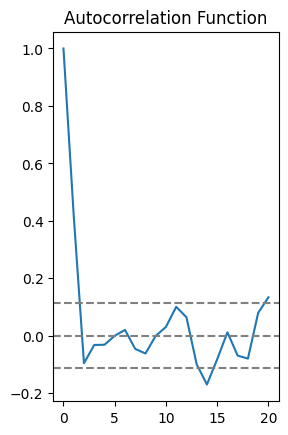

In [28]:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96 / np.sqrt(len(csd)), linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(csd)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

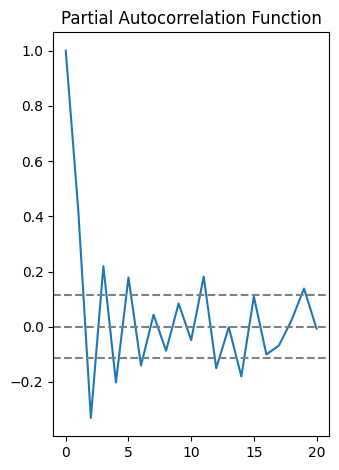

In [29]:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96 / np.sqrt(len(csd)), linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(csd)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show(block=False)

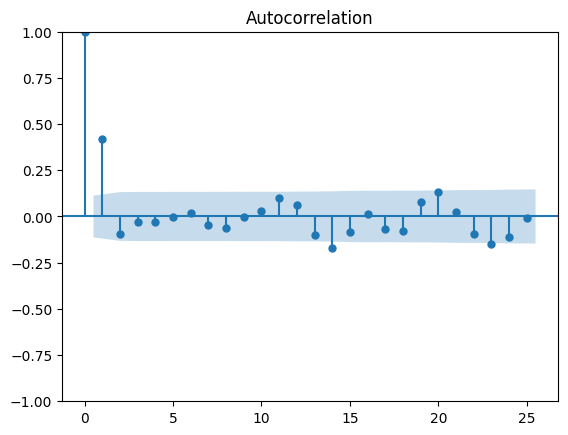

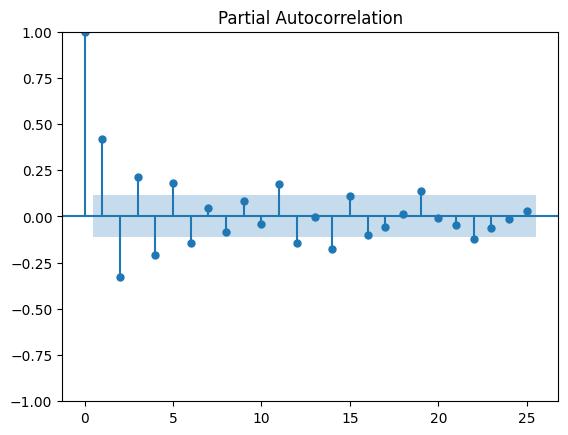

In [30]:
plot_acf(df_stationary['Close Second Difference'].dropna())
pyplot.show()
plot_pacf(df_stationary['Close Second Difference'].dropna())
pyplot.show()

For the ACF plot, we will neglect the first bar at 0 point because this refers to autocorrelation. Thus, we get q value equal to 1.

For the PACF plot, we will neglect the first bar at 0 point because this refers to autocorrelation. Thus, we get p value equal to 1.


# Splitting of dataset for Auto-Regression model

In [31]:
close = csd
train = close[:len(close)-10]
test = close[len(close)-10:]

# Function to calculate Relative Strength Index

**Relative Strenght Index(RSI)** measures the speed and magnitude of a security's recent price changes to evaluate overvalued or undervalued conditions in the price of that security.

In [32]:
def compute_rsi(data, window=14):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi


# Function to calculate Moving Average Convergence Divergence

**Moving Average Convergence Divergence(MACD)** is a popular technical momentum indicator, calculated for use with a variety of exponential moving averages (EMAs) and used to assess the power of price movement in a market.

In [33]:
def compute_macd(data, short_window=12, long_window=26):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=9, adjust=False).mean()
    return macd, signal_line


# Function to calculate On Balance Volume

**On-balance volume(OBV)** is a technical trading momentum indicator that uses volume flow to predict changes in stock price.

In [34]:
def compute_obv(prices, volumes):
    # Initialize OBV with the first volume
    obv = [volumes.iloc[0]]

    # Calculate OBV for the remaining data points
    for i in range(1, len(prices)):
        if prices.iloc[i] > prices.iloc[i - 1]:
            obv.append(obv[-1] + volumes.iloc[i])
        elif prices.iloc[i] < prices.iloc[i - 1]:
            obv.append(obv[-1] - volumes.iloc[i])
        else:
            obv.append(obv[-1])

    return pd.Series(obv, index=prices.index)


# Training and Validation of Model for "Close"

**Moving average** (rolling average or running average) is a calculation to analyze data points by creating a series of averages of different selections of the full data set.

**Open Percentage Change** is the difference coming after subtracting the old value from the new value and then divide by the old value. And the final answer will be multiplied by 100 to show it as a percentage.

**Volume Moving Average (VMA)** is like any simple moving average, except that it is applied it to volume rather than to price data.

**The Volume Percent Change** compares the stock's trading volume from the previous day with the number of shares traded on an average daily basis over the last 50 trading sessions.

**Volume RSI (Relative Strength Index)** is quite similar to the price based RSI with difference that up-volume and down-volume are used in the RSI formula instead changes in price. 

**Volume Short MA** is like any simple moving average, except that it is applied it to volume rather than to price data over a short period of time.

**Volume Long MA** is like any simple moving average, except that it is applied it to volume rather than to price data over a long period of time.

**Volatility Breakout** is when the asset price breaks above the upper band or below the lower band, it is considered a sign of high volatility and a potential trend reversal.

In [35]:


import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Load your time series data
ts_data = pd.read_csv(train_path)

# Calculate moving average for the "Open" price
ts_data['Moving_Average'] = ts_data['Open'].rolling(window=2).mean()
ts_data['Moving_Average'].iloc[0] = ts_data['Open'].iloc[0]

# Calculate additional features for the "Open" price
ts_data['Open_Percentage_Change'] = ts_data['Open'].pct_change()
ts_data['Short_MA'] = ts_data['Open'].rolling(window=10).mean()
ts_data['Long_MA'] = ts_data['Open'].rolling(window=50).mean()

ts_data['RSI'] = compute_rsi(ts_data['Open'])
macd, _ = compute_macd(ts_data['Open'])  # Only store 'macd'
ts_data['Trend_MACD'] = macd

# Calculate moving average for the "Volume"
ts_data['Vol_Moving_Average'] = ts_data['Volume'].rolling(window=2).mean()
ts_data['Vol_Moving_Average'].iloc[0] = ts_data['Volume'].iloc[0]
ts_data['Volume_Percentage_Change'] = ts_data['Volume'].pct_change()
ts_data['Vol_Short_MA'] = ts_data['Volume'].rolling(window=10).mean()
ts_data['Vol_Long_MA'] = ts_data['Volume'].rolling(window=50).mean()

ts_data['Vol_RSI'] = compute_rsi(ts_data['Volume'])
ts_data['Volatility_BBM'] = ts_data['Volume'].rolling(window=20).mean()
ts_data['Volatility_BBW'] = ts_data['Volume'].rolling(window=20).std()
ts_data['Volatility_BBP'] = (ts_data['Volume'] - ts_data['Volatility_BBM']) / (2 * ts_data['Volatility_BBW'])
ts_data['Vol_Momentum_RSI'] = ts_data['Volume'].diff(14)


ts_data['Volume_OBV'] = compute_obv(ts_data['Open'], ts_data['Volume'])

# Split the data into training, validation, and test sets
train_size = 0.7  # 70% of the data for training
validation_size = 0.15  # 15% of the data for validation
test_size = 0.15  # 15% of the data for testing

train_data, temp_data = train_test_split(ts_data, train_size=train_size, shuffle=False)
validation_data, test_data = train_test_split(temp_data, train_size=validation_size / (validation_size + test_size), shuffle=False)

# Define your target variable (closing prices) and exogenous variables (features)
y_train = train_data['Close']
exog_train = train_data.drop(['Date', 'Close', 'Strategy'], axis=1)

y_validation = validation_data['Close']
exog_validation = validation_data.drop(['Date', 'Close', 'Strategy'], axis=1)

y_test = test_data['Close']
exog_test = test_data.drop(['Date', 'Close', 'Strategy'], axis=1)

# Handling missing values by filling with the mean
exog_train = exog_train.fillna(exog_train.mean())
exog_validation = exog_validation.fillna(exog_train.mean())  # Filling with the training mean
exog_test = exog_test.fillna(exog_train.mean())  # Filling with the training mean

# Handling infinite values by replacing with a large finite number
exog_train = exog_train.replace([np.inf, -np.inf], 1e10)
exog_validation = exog_validation.replace([np.inf, -np.inf], 1e10)
exog_test = exog_test.replace([np.inf, -np.inf], 1e10)

# Train the SARIMA model on the training data
ts_model = sm.tsa.SARIMAX(y_train,
                          exog=exog_train,
                          order=(1, 1, 1),
                          seasonal_order=(0, 0, 0, 0),
                          enforce_stationarity=True,
                          enforce_invertibility=True)
ts_results = ts_model.fit()

# Make forecasts for the validation data
forecast_steps_validation = len(validation_data)
validation_forecast = ts_results.get_forecast(steps=forecast_steps_validation, exog=exog_validation)

# Calculate Accuracy (e.g., Mean Absolute Error) on the validation data
mae_validation = mean_absolute_error(y_validation, validation_forecast.predicted_mean)
print(f"Mean Absolute Error (MAE) on Validation Data: {mae_validation}")

# Make forecasts for the test data
forecast_steps_test = len(test_data)
test_forecast = ts_results.get_forecast(steps=forecast_steps_test, exog=exog_test)

# Calculate Accuracy (e.g., Mean Absolute Error) on the test data
mae_test = mean_absolute_error(y_test, test_forecast.predicted_mean)
print(f"Mean Absolute Error (MAE) on Test Data: {mae_test}")


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.38962D+00    |proj g|=  4.11861D+10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22      1     21      1     0     0   4.119D+10   2.390D+00
  F =   2.3896203122580921     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Mean Absolute Error (MAE) on Validation Data: 9.175919744815682
Mean Absolute Error (MAE) on Test Data: 27.688120144782932



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


**Reason for choosing SARIMAX:**

SARIMA (Seasonal AutoRegressive Integrated Moving Average) is a robust and widely-used time series forecasting model designed to capture both seasonal and non-seasonal patterns within time series data. It incorporates autoregressive (AR) and moving average (MA) components, as well as integration (I) for differencing non-stationary data, making it suitable for a wide range of real-world applications. SARIMA's model order can be selected based on criteria like AIC and BIC, helping to balance model.


# Applying the model on test.csv for "Close"

In [36]:
# Load the test data
test_data = pd.read_csv(test_path)


# Calculate moving average for the "Open" price
test_data['Moving_Average'] = test_data['Open'].rolling(window=2).mean()
test_data['Moving_Average'].iloc[0] = test_data['Open'].iloc[0]

# Calculate additional features for the "Open" price
test_data['Open_Percentage_Change'] = test_data['Open'].pct_change()
test_data['Short_MA'] = test_data['Open'].rolling(window=10).mean()
test_data['Long_MA'] = test_data['Open'].rolling(window=50).mean()

test_data['RSI'] = compute_rsi(test_data['Open'])
macd, _ = compute_macd(test_data['Open'])  # Only store 'macd'
test_data['Trend_MACD'] = macd

# Calculate moving average for the "Volume"
test_data['Vol_Moving_Average'] = test_data['Volume'].rolling(window=2).mean()
test_data['Vol_Moving_Average'].iloc[0] = test_data['Volume'].iloc[0]
test_data['Volume_Percentage_Change'] = test_data['Volume'].pct_change()
test_data['Vol_Short_MA'] = test_data['Volume'].rolling(window=10).mean()
test_data['Vol_Long_MA'] = test_data['Volume'].rolling(window=50).mean()

test_data['Vol_RSI'] = compute_rsi(test_data['Volume'])
test_data['Volatility_BBM'] = test_data['Volume'].rolling(window=20).mean()
test_data['Volatility_BBW'] = test_data['Volume'].rolling(window=20).std()
test_data['Volatility_BBP'] = (test_data['Volume'] - test_data['Volatility_BBM']) / (2 * test_data['Volatility_BBW'])
test_data['Vol_Momentum_RSI'] = test_data['Volume'].diff(14)

test_data['Volume_OBV'] = compute_obv(test_data['Open'], test_data['Volume'])

# Define your exogenous variables for the test data
exog_test = test_data.drop(['Date'], axis=1)

exog_test = exog_test.fillna(exog_train.mean())  # Filling with the training mean

exog_test = exog_test.replace([np.inf, -np.inf], 1e10)

# Make forecasts for the test data
forecast_steps_test = len(test_data)
test_forecast = ts_results.get_forecast(steps=forecast_steps_test, exog=exog_test)

# Extract the predicted closing prices
predicted_closing_prices = test_forecast.predicted_mean
test_data['Close'] = predicted_closing_prices.values

# Save the DataFrame to a CSV file
test_data.to_csv('/kaggle/working/test_predictions_with_id.csv', index=False)


# Splitting and Validating the model for "Strategy"

**Simple Moving Average (SMA)** refers to a stock's average closing price over a specified period.

**Standard deviation (STD)** is a measure of the amount of variation or dispersion of a set of values.

**Close_Price_ROC** calculates rate of change of close price.

**Momentum** of a stock is the difference between the current closing price of the stock and the closing price 'n' days ago.

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# Load your time series data
ts_data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')

# Encode the 'Strategy' column as integers
label_encoder = LabelEncoder()
ts_data['Strategy'] = label_encoder.fit_transform(ts_data['Strategy'])

# Calculate moving average for the "Open" price
ts_data['Moving_Average'] = ts_data['Open'].rolling(window=2).mean()
ts_data['Moving_Average'].iloc[0] = ts_data['Open'].iloc[0]

# Calculate additional features for the "Open" price
ts_data['Open_Percentage_Change'] = ts_data['Open'].pct_change()
ts_data['Short_MA'] = ts_data['Open'].rolling(window=10).mean()
ts_data['Long_MA'] = ts_data['Open'].rolling(window=50).mean()

ts_data['RSI'] = compute_rsi(ts_data['Open'])
macd, _ = compute_macd(ts_data['Open'])  # Only store 'macd'
ts_data['Trend_MACD'] = macd

# Calculate moving average for the "Volume"
ts_data['Vol_Moving_Average'] = ts_data['Volume'].rolling(window=2).mean()
ts_data['Vol_Moving_Average'].iloc[0] = ts_data['Volume'].iloc[0]
ts_data['Volume_Percentage_Change'] = ts_data['Volume'].pct_change()
ts_data['Vol_Short_MA'] = ts_data['Volume'].rolling(window=10).mean()
ts_data['Vol_Long_MA'] = ts_data['Volume'].rolling(window=50).mean()

ts_data['Vol_RSI'] = compute_rsi(ts_data['Volume'])
ts_data['Volatility_BBM'] = ts_data['Volume'].rolling(window=20).mean()
ts_data['Volatility_BBW'] = ts_data['Volume'].rolling(window=20).std()
ts_data['Volatility_BBP'] = (ts_data['Volume'] - ts_data['Volatility_BBM']) / (2 * ts_data['Volatility_BBW'])
ts_data['Vol_Momentum_RSI'] = ts_data['Volume'].diff(14)

# Calculate additional features for the "Close" price
ts_data['Close_Percentage_Change'] = ts_data['Close'].pct_change()
ts_data['Close_Short_MA'] = ts_data['Close'].rolling(window=10).mean()
ts_data['Close_Long_MA'] = ts_data['Close'].rolling(window=50).mean()
ts_data['Close_Percentage_Change'] = ts_data['Close'].pct_change()

# Calculate the SMA of the close price
ts_data['Close_SMA'] = ts_data['Close'].rolling(window=20).mean()

# Calculate the standard deviation of the close price
ts_data['Close_STD'] = ts_data['Close'].rolling(window=20).std()

# Calculate the upper and lower Bollinger Bands
ts_data['Close_Bollinger_Upper'] = ts_data['Close_SMA'] + 2 * ts_data['Close_STD']
ts_data['Close_Bollinger_Lower'] = ts_data['Close_SMA'] - 2 * ts_data['Close_STD']


ts_data['Close_Close_vs_Short_MA'] = ts_data['Close'] - ts_data['Close_Short_MA']
ts_data['Close_Close_vs_Long_MA'] = ts_data['Close'] - ts_data['Close_Long_MA']
ts_data['Close_Price_Momentum'] = ts_data['Close'].diff(14)

ts_data['Close_Price_RoC_1'] = ts_data['Close'].pct_change(periods=1)
ts_data['Close_Price_RoC_5'] = ts_data['Close'].pct_change(periods=5)
ts_data['Close_Price_RoC_20'] = ts_data['Close'].pct_change(periods=20)

ts_data['Open_Volume_Product'] = ts_data['Open'] * ts_data['Volume']
ts_data['Open_Volume_Ratio'] = ts_data['Open'] / ts_data['Volume']

ts_data['RSI'] = compute_rsi(ts_data['Close'])







ts_data['Volume_OBV'] = compute_obv(ts_data['Open'], ts_data['Volume'])

# Split the data into training and testing sets
train_size = 0.7  # 70% of the data for training
test_size = 0.3  # 30% of the data for testing

train_data, test_data = train_test_split(ts_data, train_size=train_size, shuffle=False)

# Define your target variable (Strategy) and exogenous variables (features)
y_train = train_data['Strategy']
exog_train = train_data.drop(['Date', 'Strategy'], axis=1)

y_test = test_data['Strategy']
exog_test = test_data.drop(['Date', 'Strategy'], axis=1)

# Handling missing values by filling with the mean
exog_train = exog_train.fillna(exog_train.mean())
exog_test = exog_test.fillna(exog_train.mean())  # Filling with the training mean

# Handling infinite values by replacing with a large finite number
exog_train = exog_train.replace([np.inf, -np.inf], 1e10)
exog_test = exog_test.replace([np.inf, -np.inf], 1e10)

clf = XGBClassifier(n_estimators=100, random_state=0)
clf.fit(exog_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(exog_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(f"Accuracy: {accuracy}")
print(report)


Accuracy: 0.6888888888888889
              precision    recall  f1-score   support

         Buy       0.81      0.62      0.70        34
        Hold       0.62      0.88      0.73        42
        Sell       1.00      0.29      0.44        14

    accuracy                           0.69        90
   macro avg       0.81      0.59      0.62        90
weighted avg       0.75      0.69      0.67        90



**Reason for choosing XGBoost:**

XGBoost, or eXtreme Gradient Boosting, is a preferred model for predicting stock price strategies due to its exceptional capabilities in handling complex, non-linear relationships within financial time series data. As an ensemble learning method, it combines the predictions of multiple models to create a stronger, more accurate predictor, which is crucial for capturing both short-term and long-term trends in stock prices. 

With built-in regularization techniques, it prevents overfitting and generalizes well to unseen data, critical in the noisy world of stock markets. XGBoost's feature importance ranking aids in understanding the key drivers of stock price movements, while its flexibility, efficiency, and wide adoption in the financial industry make it a reliable choice for quantitative trading and stock price prediction applications.

Moreover, its fine-tuning capabilities and handling of imbalanced data further enhance its appeal for predicting stock strategies, though it is essential to acknowledge that stock markets remain highly unpredictable, and careful evaluation and risk management are paramount.


# Applying the model on test.csv for "Strategy"

In [38]:
# Load your test data
test_data = pd.read_csv('/kaggle/working/test_predictions_with_id.csv')

# Calculate moving average for the "Open" price
test_data['Moving_Average'] = test_data['Open'].rolling(window=2).mean()
test_data['Moving_Average'].iloc[0] = test_data['Open'].iloc[0]

# Calculate additional features for the "Open" price
test_data['Open_Percentage_Change'] = test_data['Open'].pct_change()
test_data['Short_MA'] = test_data['Open'].rolling(window=10).mean()
test_data['Long_MA'] = test_data['Open'].rolling(window=50).mean()

test_data['RSI'] = compute_rsi(test_data['Open'])
macd, _ = compute_macd(test_data['Open'])  # Only store 'macd'
test_data['Trend_MACD'] = macd

# Calculate moving average for the "Volume"
test_data['Vol_Moving_Average'] = test_data['Volume'].rolling(window=2).mean()
test_data['Vol_Moving_Average'].iloc[0] = test_data['Volume'].iloc[0]
test_data['Volume_Percentage_Change'] = test_data['Volume'].pct_change()
test_data['Vol_Short_MA'] = test_data['Volume'].rolling(window=10).mean()
test_data['Vol_Long_MA'] = test_data['Volume'].rolling(window=50).mean()

test_data['Vol_RSI'] = compute_rsi(test_data['Volume'])
test_data['Volatility_BBM'] = test_data['Volume'].rolling(window=20).mean()
test_data['Volatility_BBW'] = test_data['Volume'].rolling(window=20).std()
test_data['Volatility_BBP'] = (test_data['Volume'] - test_data['Volatility_BBM']) / (2 * test_data['Volatility_BBW'])
test_data['Vol_Momentum_RSI'] = test_data['Volume'].diff(14)
test_data['Volume_OBV'] = compute_obv(test_data['Open'], test_data['Volume'])


test_data['Close_Percentage_Change'] = ts_data['Close'].pct_change()
test_data['Close_Short_MA'] = ts_data['Close'].rolling(window=10).mean()
test_data['Close_Long_MA'] = ts_data['Close'].rolling(window=50).mean()
test_data['Close_SMA'] = test_data['Close'].rolling(window=20).mean()
test_data['Close_STD'] = test_data['Close'].rolling(window=20).std()
test_data['Close_Bollinger_Upper'] = test_data['Close_SMA'] + 2 * test_data['Close_STD']
test_data['Close_Bollinger_Lower'] = test_data['Close_SMA'] - 2 * test_data['Close_STD']
test_data['Close_Close_vs_Short_MA'] = test_data['Close'] - test_data['Close_Short_MA']
test_data['Close_Close_vs_Long_MA'] = test_data['Close'] - test_data['Close_Long_MA']
test_data['Close_Price_Momentum'] = test_data['Close'].diff(14)
test_data['Close_Price_RoC_1'] = test_data['Close'].pct_change(periods=1)
test_data['Close_Price_RoC_5'] = test_data['Close'].pct_change(periods=5)
test_data['Close_Price_RoC_20'] = test_data['Close'].pct_change(periods=20)
test_data['Open_Volume_Product'] = test_data['Open'] * test_data['Volume']
test_data['Open_Volume_Ratio'] = test_data['Open'] / test_data['Volume']
test_data['Open_Volume_PercentageChange_Ratio'] = test_data['Open_Percentage_Change'] / test_data['Volume_Percentage_Change']
test_data['RSI'] = compute_rsi(test_data['Close'])

exog_test = test_data.drop(['Date'], axis=1)

# Handling missing values by filling with the mean
exog_test = exog_test.fillna(exog_train.mean())  # Filling with the training mean

# Handling infinite values by replacing with a large finite number
exog_test = exog_test.replace([np.inf, -np.inf], 1e10)

# Reorder columns in exog_test to match the order used during training
exog_test = exog_test[exog_train.columns]

# Make predictions on the test data
test_predictions = clf.predict(exog_test)

# Add the predicted strategies as a new column in the test data
test_data['Predicted_Strategy'] = label_encoder.inverse_transform(test_predictions)

# Save the test data with predicted strategies to a new CSV file
test_data.to_csv('/kaggle/working/test_with_predicted_strategyxg.csv', index=False)

# Extract the required columns from the test data
submission_data = test_data[['id', 'Date', 'Close', 'Predicted_Strategy']]

# Rename the 'Predicted_Strategy' column to 'Strategy'
submission_data = submission_data.rename(columns={'Predicted_Strategy': 'Strategy'})

# Save the submission data to a CSV file
submission_data.to_csv('/kaggle/working/submission.csv', index=False)